# Предсказание температуры

Необходимо предсказать температуру на каждый день в течение следующих 730 дней.
<br>Для выполнения необходио создать файл, в котором будет одна колонка `Temperature`, в которой содержатся 730 предсказаний.

### Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import statsmodels.tsa.api as smt
import scipy.stats as scs
#import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

Установка констант

In [2]:
#количество дней прогноза
PREDICTIONS = 730

## EDA

In [3]:
#чтение файла с распознаванием дат и установкой даты в индекс
df = pd.read_csv('temperature.csv', parse_dates=['Time'], index_col=['Time'])
df.info()
df.sample()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2920 entries, 2010-01-01 to 2017-12-29
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  2920 non-null   float64
dtypes: float64(1)
memory usage: 45.6 KB


,Temperature
Time,
2012-02-04,15.7


In [4]:
'количество уникальных значений температуры:', len(df['Temperature'].unique())

('количество уникальных значений температуры:', 219)

Распределение целевой переменной

In [5]:
df['Temperature'].describe()

count    2920.000000
mean       10.664144
std         3.927826
min         0.000000
25%         7.900000
50%        10.500000
75%        13.300000
max        26.000000
Name: Temperature, dtype: float64

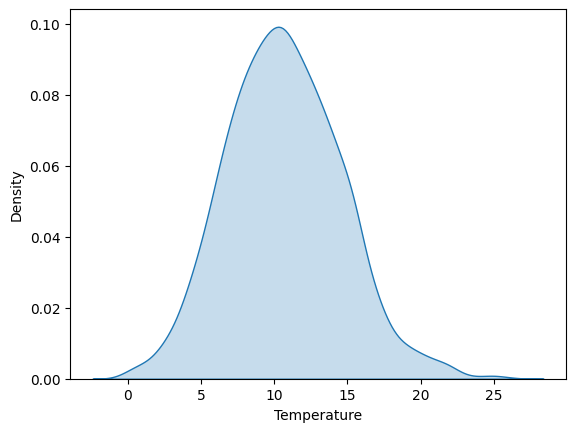

In [6]:
sns.kdeplot(df, x='Temperature', clip=(-10, 50), fill=True);

Вывод:
- медианное значение распределения практически равно среднему, можно сделать заключение о нормальности распределения, что подтверждается визуализацией

Распределение целевого признака по датам

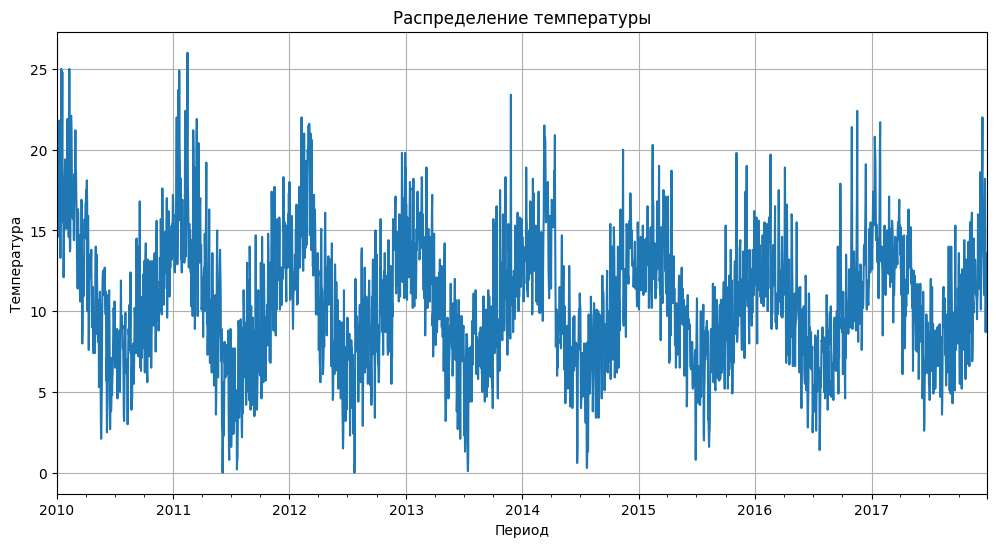

In [7]:
df['Temperature'].plot(figsize=(12,6));
plt.title("Распределение температуры")
plt.xlabel("Период")
plt.ylabel("Температура")
plt.grid();

Вывод:
- на графике явно прослеживается сезонность, что вполне логично

Посмотрим на средние температуры по месяцам

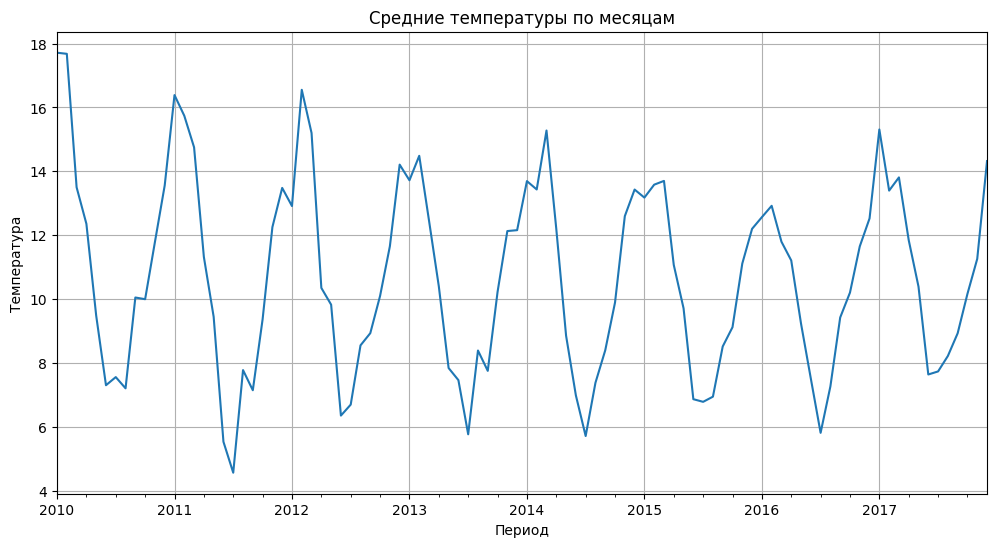

In [8]:
df_resample = df['Temperature'].resample('1M').mean()
df_resample.plot(figsize=(12,6))
plt.title("Средние температуры по месяцам")
plt.xlabel("Период")
plt.ylabel("Температура")
plt.grid();

Изучение сезонности, тренда и остатков

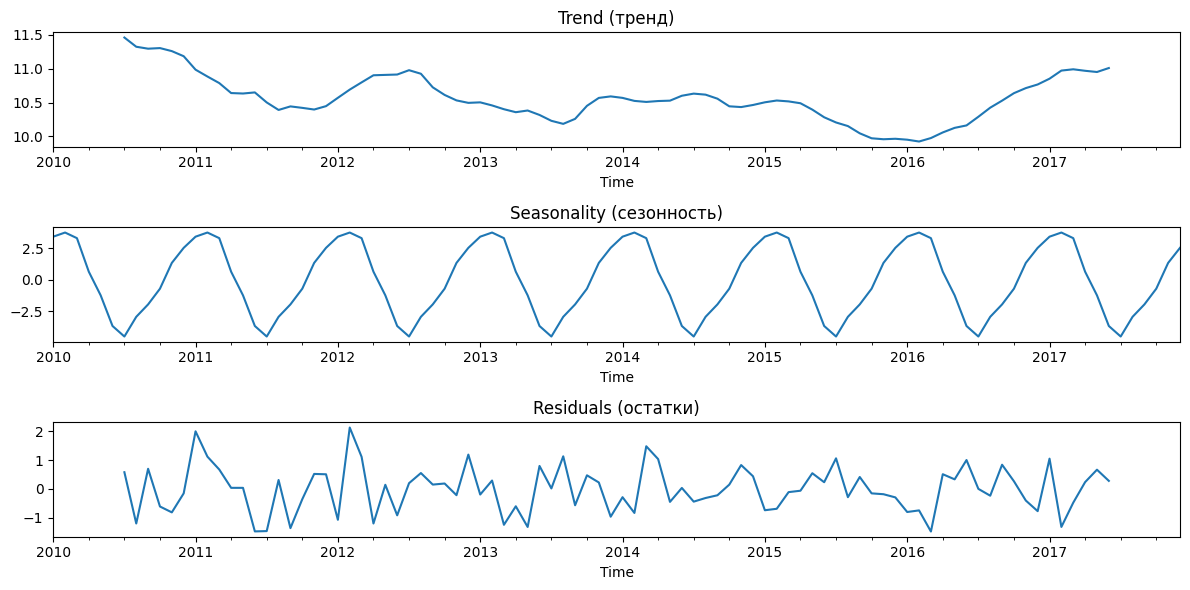

In [9]:
decomposed_units = seasonal_decompose(df_resample)

plt.figure(figsize=(12,6))
plt.subplot(311)

decomposed_units.trend.plot(ax=plt.gca())
plt.title('Trend (тренд)')
plt.subplot(312)
decomposed_units.seasonal.plot(ax=plt.gca())
plt.title('Seasonality (сезонность)')
plt.subplot(313)
decomposed_units.resid.plot(ax=plt.gca())
plt.title('Residuals (остатки)')
plt.tight_layout()

Вывод:
- наблюдается ярко выраженная сезонность
- явного тренда нет

Скользящее среднее и скользящее стандартное

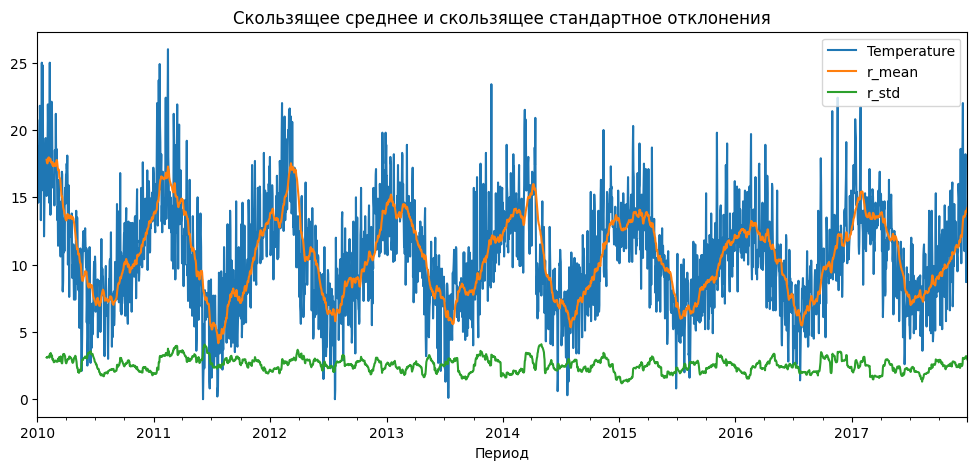

In [10]:
df_s = df.copy()
df_s['r_mean'] = df_s['Temperature'].rolling(window=30).mean()
df_s['r_std'] = df_s['Temperature'].rolling(window=30).std()

df_s.plot(figsize=(12,5))
plt.title('Скользящее среднее и скользящее стандартное отклонения')
plt.xlabel('Период');

Вывод:
- скользящее среднее имеет сезонность,
- скользящее стандартное отклонение значительных разбросов не имеет

Проверка на стационарность при помощи теста Дики-Фуллера

In [11]:
test = adfuller(df_resample)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, можем предположить, что ряд стационарен')

adf:  -2.0611678949161014
p-value:  0.2604130066713294
Critical values:  {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}
есть единичные корни, ряд не стационарен


Вывод:
- проведённый тест Дики-Фуллера говорит о нестационарности временного ряда

### Решение проблемы с нестационарностью

In [12]:
df.sample(3)

,Temperature
Time,
2012-06-06,9.4
2011-03-13,12.4
2010-04-30,7.4


Критерий Дики-Фуллера: p=0.000542


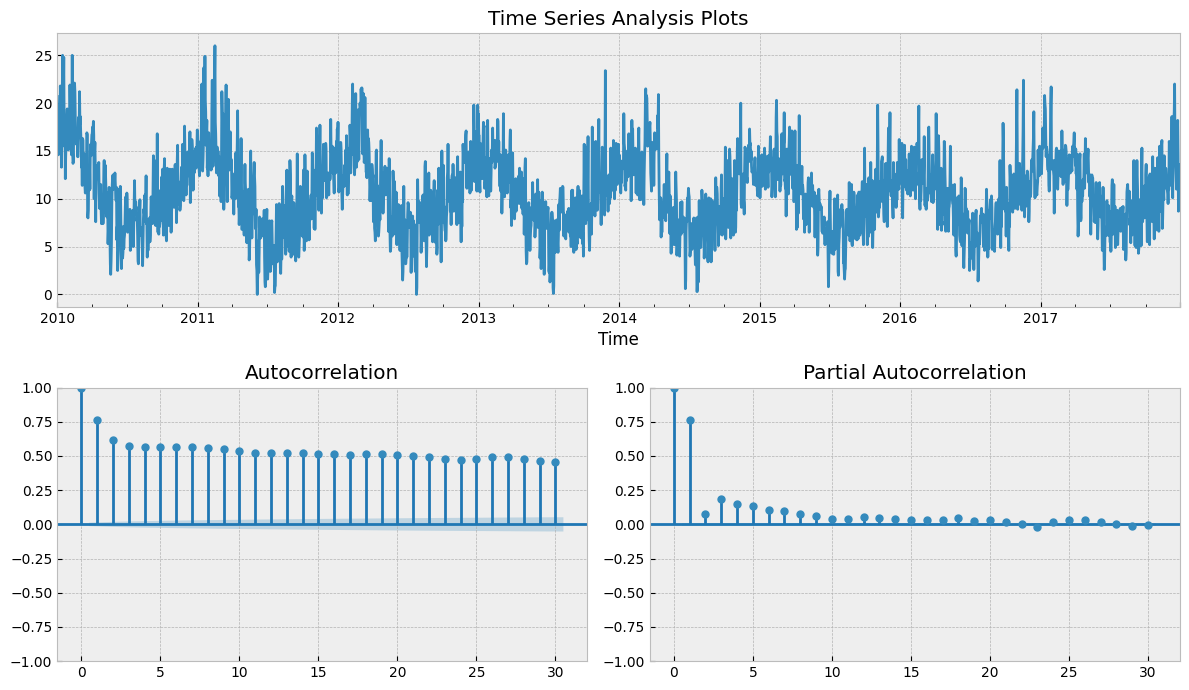

In [13]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(df.Temperature, lags=30)

## Разделение на выборки

Подготовка датафрейма

In [14]:
df_m = df.reset_index().rename(columns={'Time': 'ds', 'Temperature': 'y'})
df_m.sample(3)

,ds,y
1158,2013-03-04,11.7
1021,2012-10-18,11.9
2083,2015-09-15,7.8


Данные для обучения

In [15]:
#из датафрейма вычтен период, равный прогнозируемому
X_train = df_m[:-PREDICTIONS]
X_test = df_m[-PREDICTIONS:]

## Обучение модели Prophet

Инициализация модели и её обучение

In [16]:
model_pr = Prophet(daily_seasonality=False, #дневная сезонность
                   weekly_seasonality=False, #недельная сезонность
                   yearly_seasonality=True) #годовая сезонность

model_pr.fit(X_train)

11:53:48 - cmdstanpy - INFO - Chain [1] start processing
11:53:48 - cmdstanpy - INFO - Chain [1] done processing


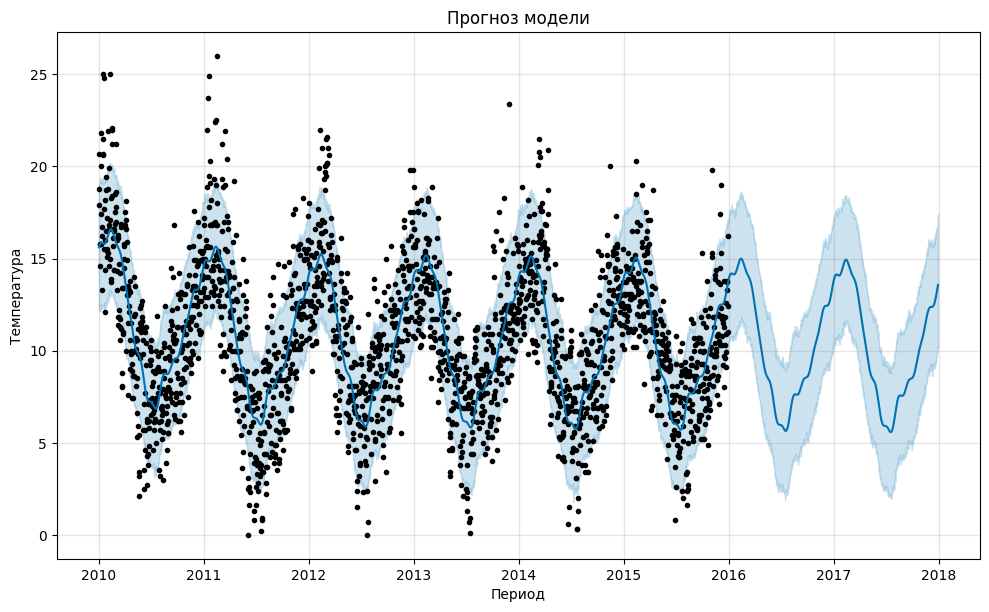

In [17]:
#получение предсказаний, отрисовка диаграммы
future = model_pr.make_future_dataframe(periods=PREDICTIONS)
forecast = model_pr.predict(future)
model_pr.plot(forecast)
plt.title("Прогноз модели")
plt.xlabel("Период")
plt.ylabel("Температура");

Вывод:
- чёрные точки - исходные данные,
- синяя линия - это модель прогноза,
- голубая область - доверительный интервал,
- по визуальному анализу можно сказать, что ошибки модели минимальны.

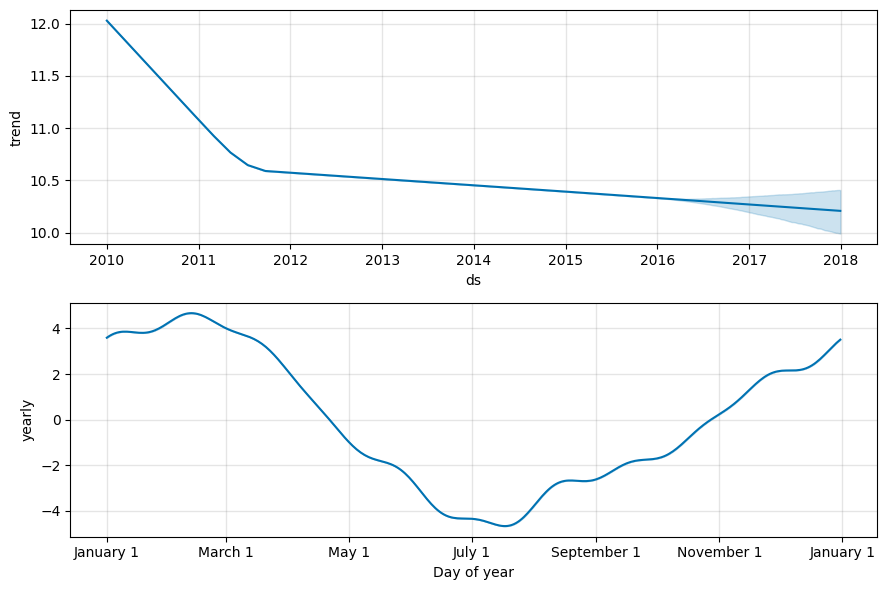

In [18]:
#сезонность
model_pr.plot_components(forecast);

Вывод:
- модель выявляет общий тренд и годовую сезонность

Проверка ошибок модели

In [19]:
df_forecast = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_m.set_index('ds'))
df_forecast['mae'] = df_forecast['y'] - df_forecast['yhat']
df_forecast['mape'] = 100*df_forecast['mae']/df_forecast['y']
                                     
print('MAPE:', round(np.mean(abs(df_forecast[-PREDICTIONS:]['mape'])), 2), '%')
print('MAE:', round(np.mean(abs(df_forecast[-PREDICTIONS:]['mae'])), 2))

MAPE: 22.16 %
MAE: 2.11


Вывод:
- модель показывает довольно большое отклонение по `MAPE` = 22.16%
- в абсолютных значениях отклонения выглядят не так критично: `MAE` = 2.11

## Обучение модели SARIMA

Разделение данных на выборки

In [20]:
X_train_s = df[:-PREDICTIONS]
X_test_s = df[-PREDICTIONS:]

Подбор оптимальных параметров

In [21]:
model_s = auto_arima(X_train_s['Temperature'],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3, 
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)

model_s.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=10612.180, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=10610.201, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=10538.216, Time=0.73 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=10396.072, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=10608.203, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=10394.948, Time=0.25 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=10396.140, Time=1.07 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=10393.066, Time=3.24 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=10393.931, Time=6.98 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=10393.992, Time=7.65 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=10394.869, Time=3.88 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=10395.116, Time=3.05 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=10395.738, Time=18.85 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=10614.165, Time=0.66 sec
 ARI

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2190
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -5023.381
Date:                Tue, 24 Oct 2023   AIC                          10054.763
Time:                        11:55:19   BIC                          10077.528
Sample:                    01-01-2010   HQIC                         10063.083
                         - 12-30-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4838      0.023     21.301      0.000       0.439       0.528
ar.L2         -0.1332      0.022     -5.949      0.000      -0.177      -0.089
ma.L1         -0.8961      0.013    -71.191      0.000      -0.921      -0.871
sigma2         5.7621      0.166     34.652      0.000       5.436       6.088
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 5.70
Prob(Q):                              0.93   Prob(JB):                         0.06
Heteroskedasticity (H):               0.81   Skew:                             0.06
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Обучение модели с лучшими подобранными параметрами

/home/denis/Documents/main_venv/main_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/denis/Documents/main_venv/main_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31697D+00    |proj g|=  8.96166D-02

At iterate    5    f=  2.29643D+00    |proj g|=  5.35570D-02

At iterate   10    f=  2.29378D+00    |proj g|=  4.58447D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   2.891D-06   2.294D+00
  F =   2.2937814601512105     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
MAPE: 0.4303799814950293
MAE: 3.1828239218519503


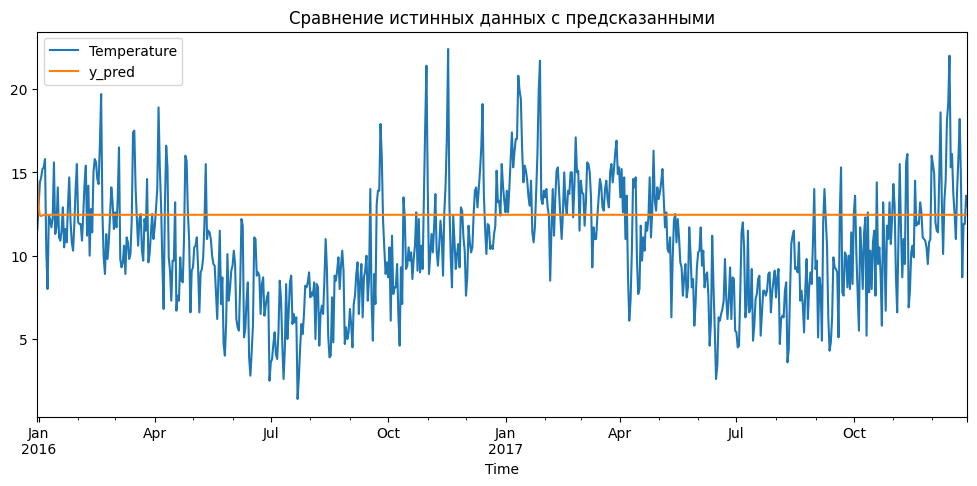

In [32]:
sarima_model = SARIMAX(X_train_s['Temperature'], order= (2,1,1), seasonal_order= (0,0,0,12))
sarima_model_fit = sarima_model.fit()

#Предсказания на тестовой выборке
start= len(X_train_s)
end= len(X_train_s) + len(X_test_s) -1
pred= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename('y_pred')

#График предсказаний на тесте
title= 'Сравнение истинных данных с предсказанными'
X_test_s['Temperature'].plot(figsize=(12,5), title=title, legend=True)
pred.plot(legend=True)


#Оценка качества модели
mae = mean_absolute_error(X_test_s['Temperature'], pred)
mape = mean_absolute_percentage_error(X_test_s['Temperature'], pred)

print('MAPE:', mape)
print('MAE:', mae)

## Получение файла с предсказаниями

In [34]:
#обучение модели на всей выборке
model_solution = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
model_solution.fit(df_m)

14:58:27 - cmdstanpy - INFO - Chain [1] start processing
14:58:27 - cmdstanpy - INFO - Chain [1] done processing


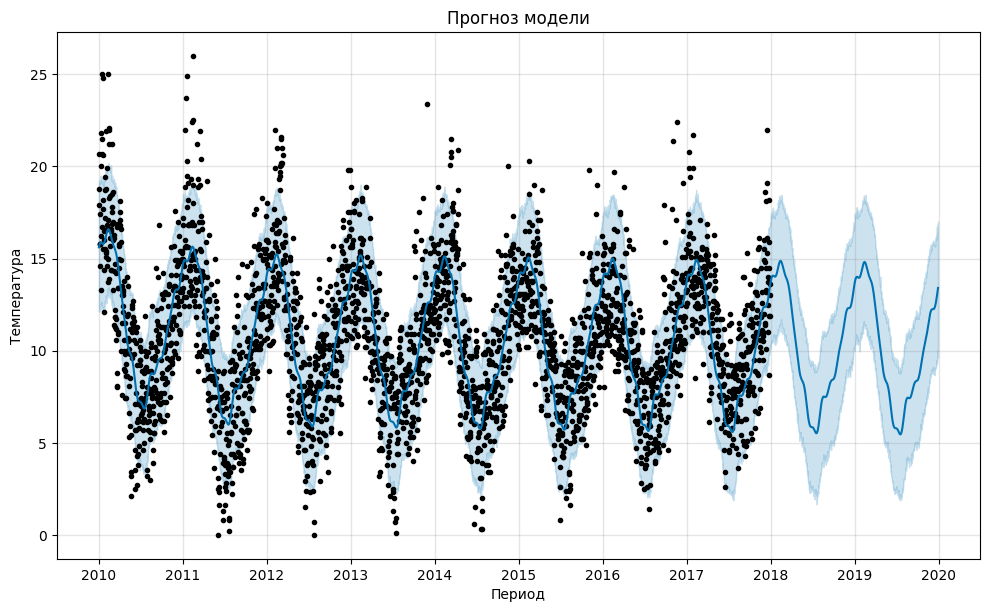

In [57]:
#получение предсказаний, отрисовка диаграммы
future_sol = model_solution.make_future_dataframe(periods=PREDICTIONS)
answer = model_pr.predict(future_sol)
model_solution.plot(answer)
plt.title("Прогноз модели")
plt.xlabel("Период")
plt.ylabel("Температура");

In [58]:
# сохранение результата в файл
answer = answer[-PREDICTIONS:].rename(columns={'yhat': 'Temperature'})['Temperature']
answer.to_csv('answer.csv', index=False)

## Заключение
- модель FBProfet даёт более высокое качество прогноза, она и использована для решения поставленной задачи.